# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Muhammad Favian Zaahir
- **Email:** favianzaahir@gmail.com
- **ID Dicoding:** MS058D5Y0648

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ipywidgets
import warnings
warnings.filterwarnings("ignore")

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from tqdm.notebook import tqdm as tq
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Input, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

## Data Preparation

### Data Loading

In [5]:
train_dir = 'seg_train/seg_train'
test_dir = 'seg_test/seg_test'
pred_dir = 'seg_pred/seg_pred'

### Data Preprocessing

#### Split Dataset

In [6]:
IMAGE_SIZE = (228, 228)
BATCH_SIZE = 32

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [8]:
classes_names = train_ds.class_names
print(classes_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [9]:
scenery_images = []

def getImagesPath(path):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            scenery_images.append(os.path.join(dirname, filename))
    return scenery_images

scenery_images = getImagesPath(pred_dir)
len(scenery_images)

7301

In [10]:
scenery_images = getImagesPath(train_dir)
len(scenery_images)

21335

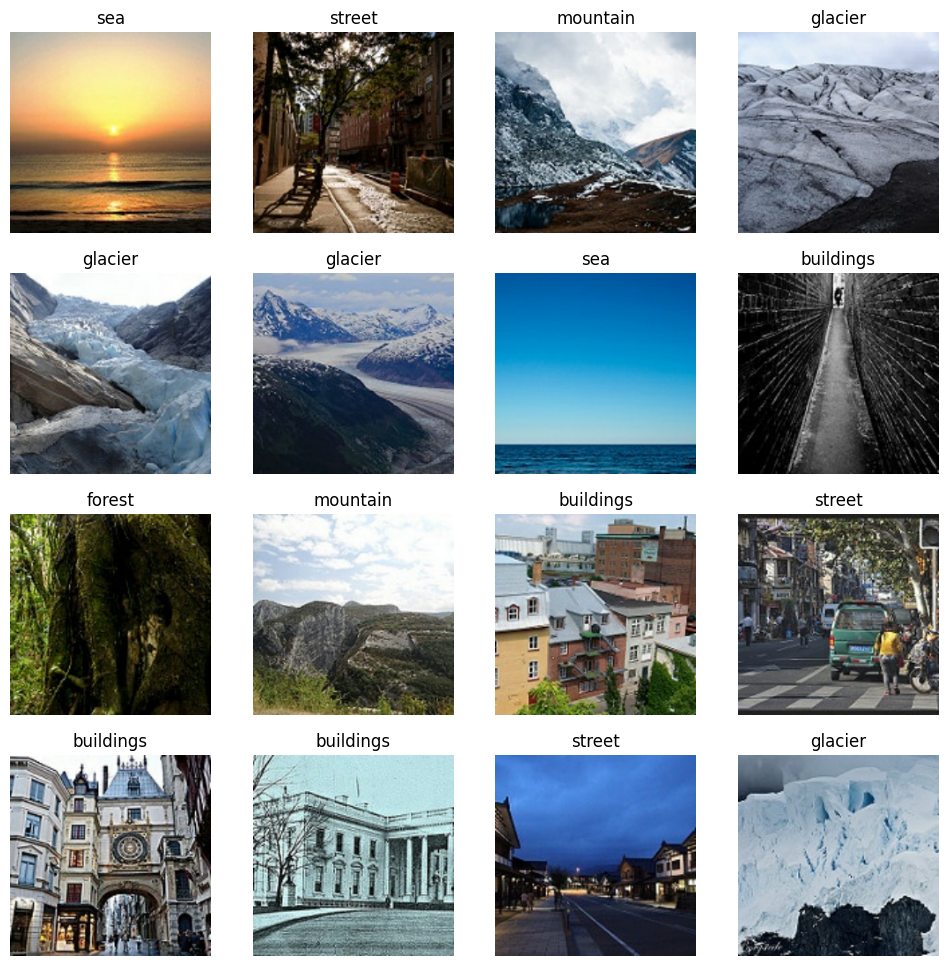

In [11]:
plt.figure(figsize=(12,12))
for images,labels in train_ds.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

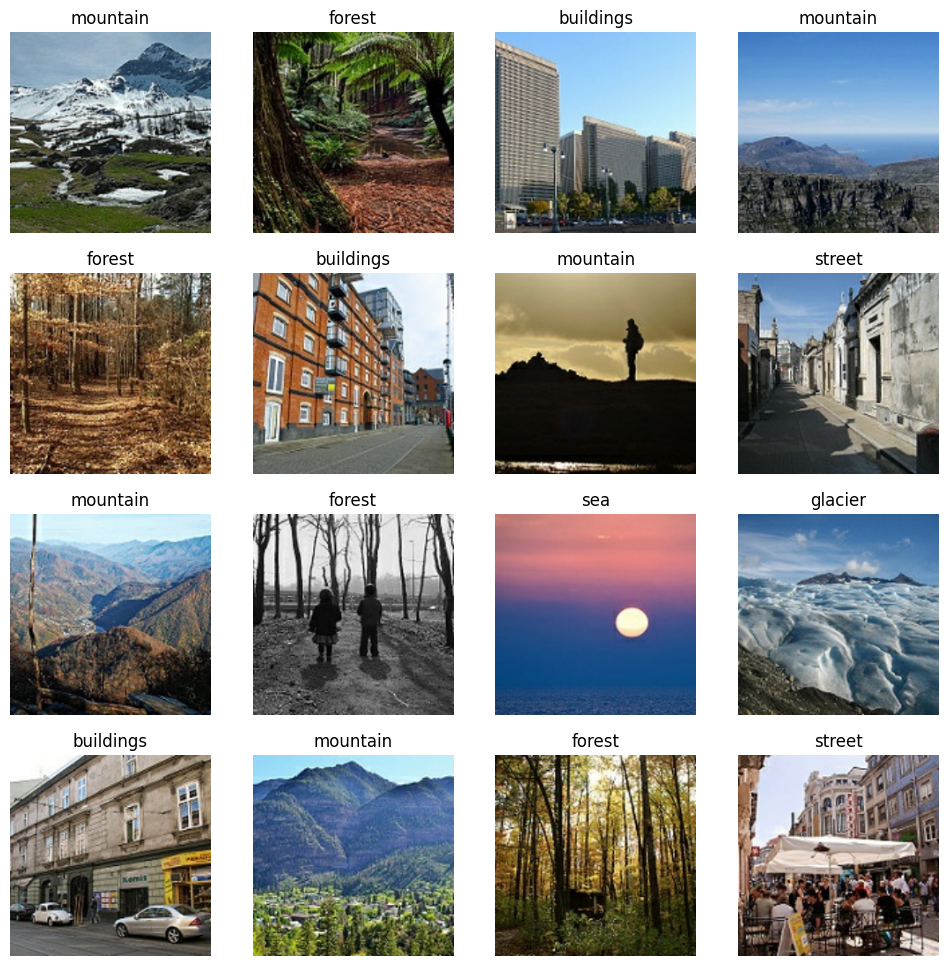

In [12]:
plt.figure(figsize=(12,12))
for images,labels in test_ds.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

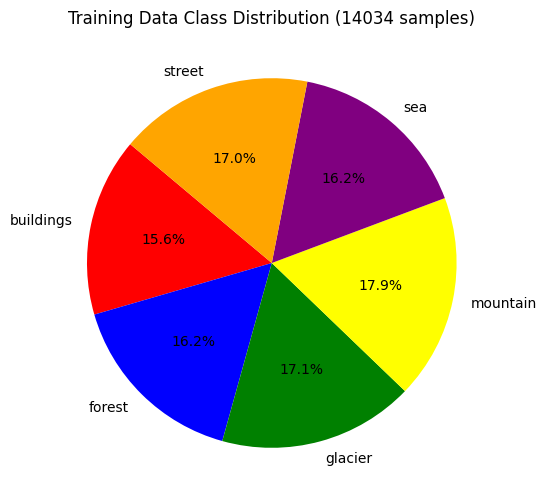

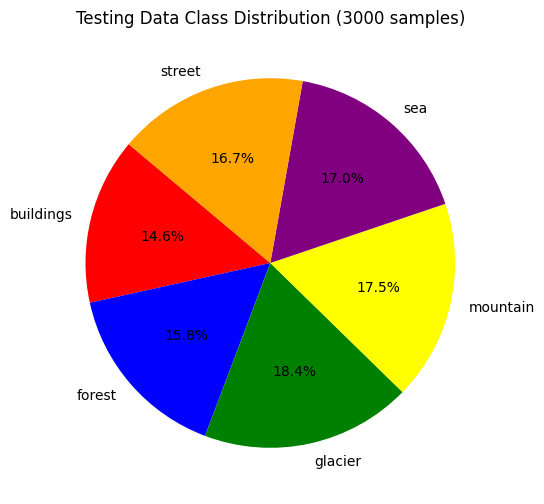

In [13]:
def get_class_counts(dataset, class_names):
    class_counts = {name: 0 for name in class_names}
    total_samples = 0
    for _, labels in dataset:
        for label in labels:
            class_counts[class_names[label.numpy()]] += 1
            total_samples += 1
    return class_counts, total_samples

train_class_counts, train_total_samples = get_class_counts(train_ds, classes_names)

plt.figure(figsize=(8, 6))
plt.pie(train_class_counts.values(),
        labels=train_class_counts.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=['red', 'blue', 'green', 'yellow', 'purple', 'orange'])
plt.title(f'Training Data Class Distribution ({train_total_samples} samples)')
plt.show()

test_class_counts, test_total_samples = get_class_counts(test_ds, classes_names)

plt.figure(figsize=(8, 6))
plt.pie(test_class_counts.values(),
        labels=test_class_counts.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=['red', 'blue', 'green', 'yellow', 'purple', 'orange'])
plt.title(f'Testing Data Class Distribution ({test_total_samples} samples)')
plt.show()

## Modelling

In [14]:
Norm_layer=tf.keras.layers.Rescaling(1/255)
train_ds=train_ds.map(lambda x , y :(Norm_layer(x),y))
test_ds=test_ds.map(lambda x , y :(Norm_layer(x),y))

In [15]:
model=Sequential()
model.add(Input(shape=(228, 228, 3)))
model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(124,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(units=len(classes_names),activation='softmax'))

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,639,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 124)            │       127,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,860,010 (7.10 MB)

 Trainable params: 1,860,010 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)

In [18]:
history=model.fit(train_ds,validation_data=test_ds,epochs=50,callbacks=[early_stopping])

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 196s 443ms/step - accuracy: 0.4625 - loss: 1.3365 - val_accuracy: 0.6270 - val_loss: 0.9315
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 412s 940ms/step - accuracy: 0.6563 - loss: 0.8684 - val_accuracy: 0.6870 - val_loss: 0.7783
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 348s 785ms/step - accuracy: 0.7367 - loss: 0.7071 - val_accuracy: 0.7893 - val_loss: 0.5912
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 115s 262ms/step - accuracy: 0.7820 - loss: 0.6088 - val_accuracy: 0.7800 - val_loss: 0.6037
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 118s 269ms/step - accuracy: 0.8194 - loss: 0.5123 - val_accuracy: 0.8090 - val_loss: 0.5525
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 157s 357ms/step - accuracy: 0.8405 - loss: 0.4537 - val_accuracy: 0.8173 - val_loss: 0.5567
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 335s 765ms/step - accuracy: 0.8559 - loss: 0.3958 - val_accuracy: 0.8290 - val_loss: 0.5266
Epoch 8/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 115s 262ms/step - accuracy: 0.8777 -

## Evaluasi dan Visualisasi

In [19]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 328ms/step - accuracy: 0.8266 - loss: 0.5452
Test accuracy: 82.90%


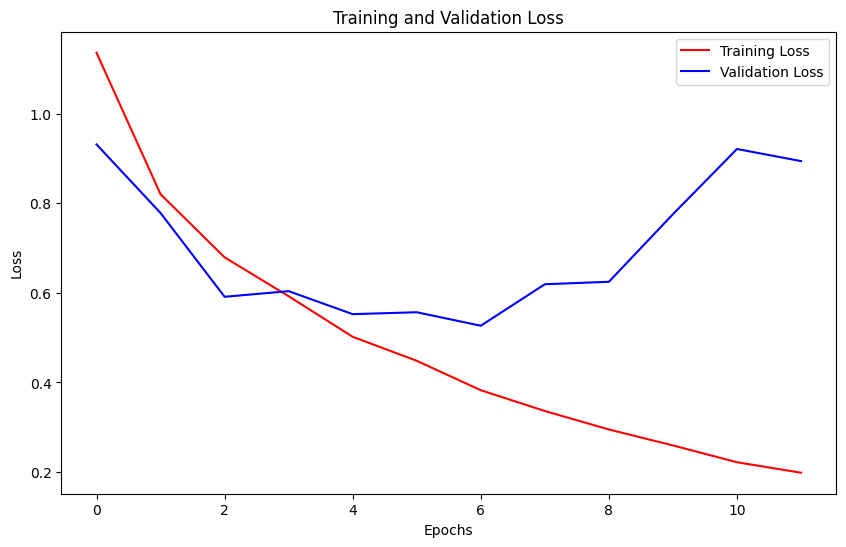

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, c="red", label="Training Loss")
plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

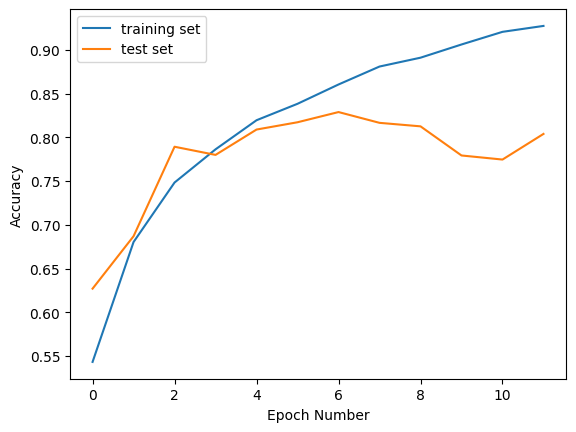

In [21]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

## Konversi Model

In [ ]:
model.save('scenery_model_keras')

output_dir = 'web_model'
tfjs.converters.save_keras_model(model, output_dir)
print(f"Model saved to {output_dir}")

## Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


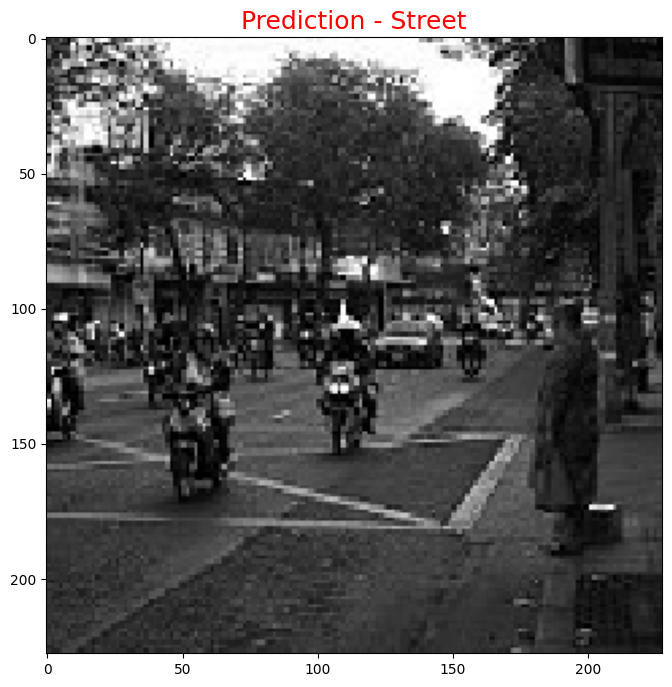

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Top 3 predictions:
street: 0.9097
forest: 0.0885
buildings: 0.0010


array([9.6070470e-04, 8.8482372e-02, 6.6600047e-04, 6.0355524e-06,
       1.5292130e-04, 9.0973192e-01], dtype=float32)

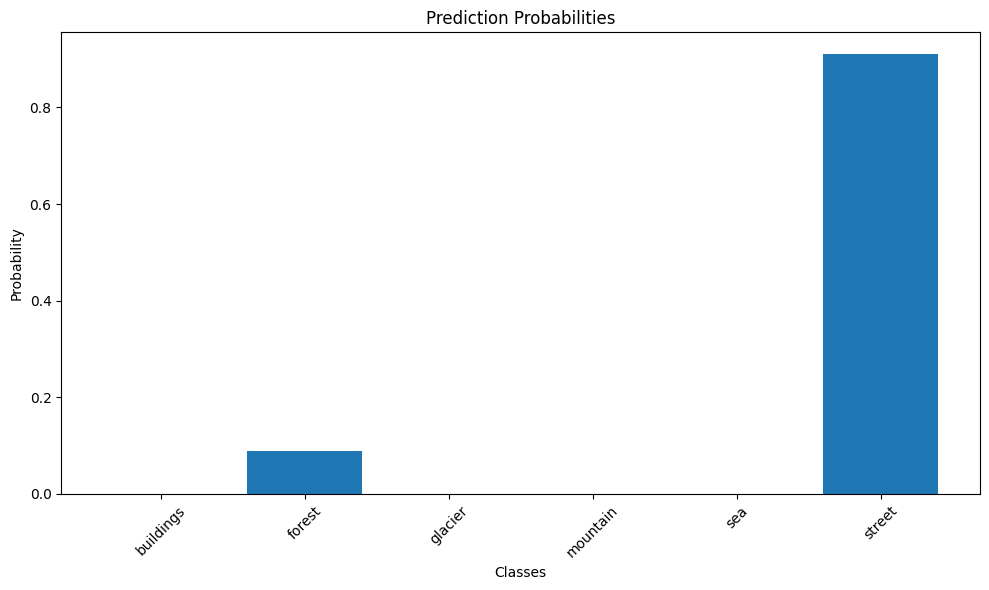

In [ ]:
test_image_path = 'seg_pred/seg_pred/3.jpg'

plt.figure(figsize=(8, 8))
predict_img(test_image_path, model)
plt.show()

def predict_with_probabilities(file_name, model):
    img = image.load_img(file_name, target_size=(228, 228))
    img_array = image.img_to_array(img)
    img_pro = np.expand_dims(img_array, axis=0)
    img_pro /= 255
    predictions = model.predict(img_pro)[0]
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes_names, predictions)
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.title('Prediction Probabilities')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    top_indices = np.argsort(predictions)[::-1][:3]
    print("Top 3 predictions:")
    for i in top_indices:
        print(f"{classes_names[i]}: {predictions[i]:.4f}")
    
    return predictions

predict_with_probabilities(test_image_path, model)